<a href="https://colab.research.google.com/github/richerram/Keras/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - Ricardo Hernandez Ramon
## Image classifier for the SVHN dataset



In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization, Conv2D, Dropout, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from scipy.io import loadmat

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Load the dataset from your Drive folder
train = loadmat('/content/gdrive/MyDrive/Coursera/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/Coursera/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:
#Exploring the files, what data is in them and how it is organized.
print (train.keys())
print (train['__header__'])
print (type(train['X']))
print (train['X'].shape)
print (train['y'].shape)
print (train['y'][7489][0])

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:09:26 2011'
<class 'numpy.ndarray'>
(32, 32, 3, 73257)
(73257, 1)
7


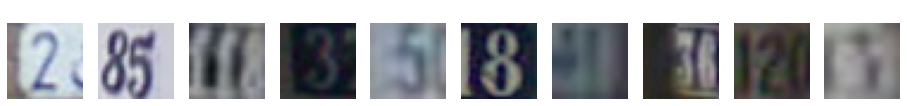

In [6]:
# Showing 10 images and their labels from the "train" set.
fig, ax = plt.subplots(1, 10, figsize=(16,16))
for i in range(10):
    j = random.randrange(0, 73256, 1)
    ax[i].set_axis_off()
    ax[i].imshow(train['X'][:,:,:,j])
    ax[i].text(10,-2.5,str(train['y'][j][0]), fontsize=16, color="white")

(32, 32)


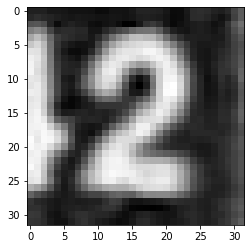

In [7]:
# Verifying how I'm going to convert the images to Grayscale
x = train['X'][:,:,:,27]
x = np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])
print (x.shape)
plt.imshow(x, cmap=plt.get_cmap("gray"))


In [8]:
# Converting all train[X] and test[X] to Grayscale and creating new arrays in the right order/scale to be processed by the Neural Network. 
# Leaving the addition of the extra axis out for the training of the Convolutional Network.

trainX = []
def togray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

for i in range(len(train['X'][0][0][0])):
  trainX.append(togray (train['X'][:,:,:,i]))
trainX = np.array(trainX)
#trainX = trainX[...,np.newaxis]

testX = []
for i in range(len(test['X'][0][0][0])):
  testX.append(togray (test['X'][:,:,:,i]))
testX = np.array(testX)
#testX = testX[...,np.newaxis]

In [9]:
# Converting the 'y' matrices to 'Categorical'.
trainY = train['y']
trainY = np.where(trainY == 10, 0, trainY)
trainY = tf.keras.utils.to_categorical(trainY)

testY = test['y']
testY = np.where(testY == 10, 0, testY)
testY = tf.keras.utils.to_categorical(testY)

In [10]:
# Verifying that all shapes and types are right.
print (type(trainX))
print (trainX.shape)
print (type(trainY))
print (trainY.shape)
print (type(testX))
print (testX.shape)
print (type(testY))
print (testY.shape)

<class 'numpy.ndarray'>
(73257, 32, 32)
<class 'numpy.ndarray'>
(73257, 10)
<class 'numpy.ndarray'>
(26032, 32, 32)
<class 'numpy.ndarray'>
(26032, 10)


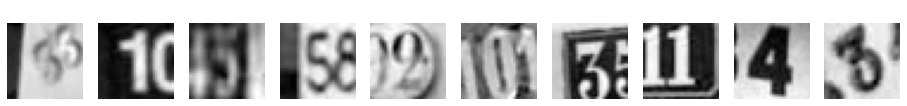

In [11]:
#Printing Grayscale images
fig, ax = plt.subplots(1, 10, figsize=(16,16))
for i in range(10):
    j = random.randrange(0, 73256, 1)
    ax[i].set_axis_off()
    ax[i].imshow(trainX[j], cmap=plt.get_cmap("gray"))
    ax[i].text(10,-2.5,str(train['y'][j][0]), fontsize=16, color="white")

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [12]:
# Flattening the 32,32 matrix

flatTrainX = [trainX[i].flatten() for i in range(len(trainX))]
flatTrainX = np.array(flatTrainX)
print(flatTrainX.shape)
flatTestX = [testX[i].flatten() for i in range(len(testX))]
flatTestX = np.array(flatTestX)
print(flatTestX.shape)

(73257, 1024)
(26032, 1024)


In [13]:
#Creating the function for the MPL network and checking the architecture.
pixels = trainX.shape[1] * trainX.shape[2]
def MPLnetwork(inputshape):
  model = Sequential([
                      Dense(inputshape, input_shape=(inputshape,), activation='relu'),
                      Dense(1024, activation='relu'),
                      Dense(1024, activation='relu'),
                      Dense(256, activation='relu'),
                      Dense(10, activation='softmax')])
  return model
model = MPLnetwork(npixels)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 3,413,770
Trainable params: 3,413,770
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Compiling the MPL model. 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Creating the 'callbacks' one for 'reducing the learning rate' and another one to 'save the best weights'.
lr_redu = tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2)
best_check = tf.keras.callbacks.ModelCheckpoint (filepath="/content/gdrive/MyDrive/Coursera/bestFlat/checkpoint", save_weights_only=True, monitor="val_loss")

In [16]:
# Running the model (fit).
history = model.fit(flatTrainX, trainY, epochs=30, batch_size=32, validation_split=0.15, callbacks=[lr_redu, best_check])

Epoch 1/10
1946/1946 [==============================] - 7s 4ms/step - loss: 3.4002 - accuracy: 0.4322 - val_loss: 1.3635 - val_accuracy: 0.5569
Epoch 2/10
1946/1946 [==============================] - 7s 4ms/step - loss: 1.3031 - accuracy: 0.5839 - val_loss: 1.2686 - val_accuracy: 0.5924
Epoch 3/10
1946/1946 [==============================] - 7s 4ms/step - loss: 1.2262 - accuracy: 0.6112 - val_loss: 1.1952 - val_accuracy: 0.6195
Epoch 4/10
1946/1946 [==============================] - 7s 4ms/step - loss: 1.1723 - accuracy: 0.6319 - val_loss: 1.2657 - val_accuracy: 0.5950
Epoch 5/10
1946/1946 [==============================] - 7s 4ms/step - loss: 1.1487 - accuracy: 0.6370 - val_loss: 1.1279 - val_accuracy: 0.6423
Epoch 6/10
1946/1946 [==============================] - 7s 4ms/step - loss: 1.1190 - accuracy: 0.6523 - val_loss: 1.1020 - val_accuracy: 0.6653
Epoch 7/10
1946/1946 [==============================] - 7s 4ms/step - loss: 1.1016 - accuracy: 0.6549 - val_loss: 1.1307 - val_accuracy:

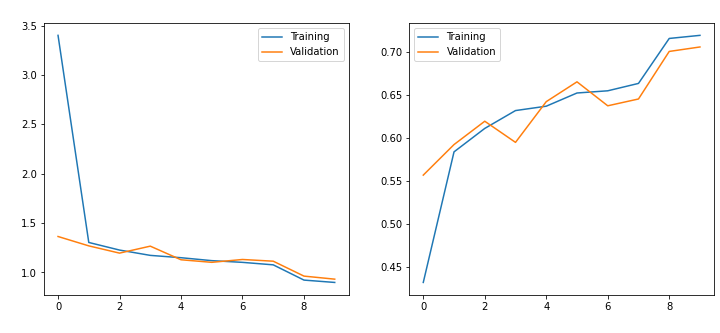

In [17]:
#Printing 'Training' and 'Validation' values agains each other.
import matplotlib.pyplot as plt
fig = plt.figure (figsize=(12, 5))
fig.add_subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MLP loss vs val_loss', color='white')
plt.xlabel('Epochs', color='white')
plt.ylabel('Loss', color='white')
plt.legend(['Training', 'Validation'])

fig.add_subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MLP accuracy vs val_accuracy', color='white')
plt.xlabel('Epochs', color='white')
plt.ylabel('Accuracy', color='white')
plt.legend(['Training', 'Validation'])

In [18]:
# Evaluating model on the test_set with 67% accuracy on the Test Set!!!!
model.evaluate(flatTestX, testY)

814/814 [==============================] - 2s 2ms/step - loss: 1.0671 - accuracy: 0.6781


[1.0670870542526245, 0.6780501008033752]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [19]:
# This time we create the variables 'trainX' and 'testX' but including the extra 'dimension' to be used in the Convolutional Network.
trainX = []
def togray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

for i in range(len(train['X'][0][0][0])):
  trainX.append(togray (train['X'][:,:,:,i]))
trainX = np.array(trainX)
trainX = trainX[...,np.newaxis]

testX = []
for i in range(len(test['X'][0][0][0])):
  testX.append(togray (test['X'][:,:,:,i]))
testX = np.array(testX)
testX = testX[...,np.newaxis]

In [129]:
# Creation of the CNN net (addint weight initialization since the training was getting stuck at 'loss=2.35', this solved it, you can refer to this paper for more info:
# http://www.cs.toronto.edu/~fritz/absps/momentum.pdf)
def CNNnetwork(inputshape, drop_rate):
  model = Sequential([
                      Conv2D(32, (3,3), activation='relu', input_shape=inputshape, padding='SAME', kernel_initializer="random_uniform"),
                      Conv2D(16, (3,3), activation='relu'),
                      MaxPooling2D((2,2)),
                      Flatten(),
                      Dense(32, activation='relu'),
                      Dropout(drop_rate),
                      Dense(16, activation='relu'),
                      Dense(10, activation='softmax')
  ])
  return model
modelCNN = CNNnetwork(trainX[0].shape, 0.3)

In [130]:
modelCNN.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 30, 30, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 3600)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)                115232    
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 16)              

In [131]:
# Compiling the model.
opt2 = tf.keras.optimizers.Adam(learning_rate=0.001)
modelCNN.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

In [132]:
# Custom callback to reduce the 'learning rate' and to save the weights of the best iteration.
lr_reduCNN = tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.9, monitor='val_loss', mode='auto')
best_checkCNN = tf.keras.callbacks.ModelCheckpoint (filepath="/content/gdrive/MyDrive/Coursera/bestCNN/checkpoint", save_weights_only=True, monitor="val_loss")

In [133]:
# Running the training of the Convolutional Network model.
CNNhistory = modelCNN.fit(trainX, trainY, epochs=30, batch_size=32, validation_split=0.15,  callbacks=[lr_reduCNN, best_checkCNN])

Epoch 1/30
1946/1946 [==============================] - 7s 4ms/step - loss: 1.6146 - accuracy: 0.4590 - val_loss: 1.0566 - val_accuracy: 0.6825
Epoch 2/30
1946/1946 [==============================] - 7s 3ms/step - loss: 1.0217 - accuracy: 0.6719 - val_loss: 0.7705 - val_accuracy: 0.7651
Epoch 3/30
1946/1946 [==============================] - 7s 4ms/step - loss: 0.8620 - accuracy: 0.7262 - val_loss: 0.6215 - val_accuracy: 0.8150
Epoch 4/30
1946/1946 [==============================] - 7s 4ms/step - loss: 0.7980 - accuracy: 0.7436 - val_loss: 0.6528 - val_accuracy: 0.8099
Epoch 5/30
1946/1946 [==============================] - 7s 4ms/step - loss: 0.7576 - accuracy: 0.7565 - val_loss: 0.5883 - val_accuracy: 0.8286
Epoch 6/30
1946/1946 [==============================] - 7s 4ms/step - loss: 0.7295 - accuracy: 0.7691 - val_loss: 0.6083 - val_accuracy: 0.8165
Epoch 7/30
1946/1946 [==============================] - 7s 4ms/step - loss: 0.6969 - accuracy: 0.7777 - val_loss: 0.5568 - val_accuracy:

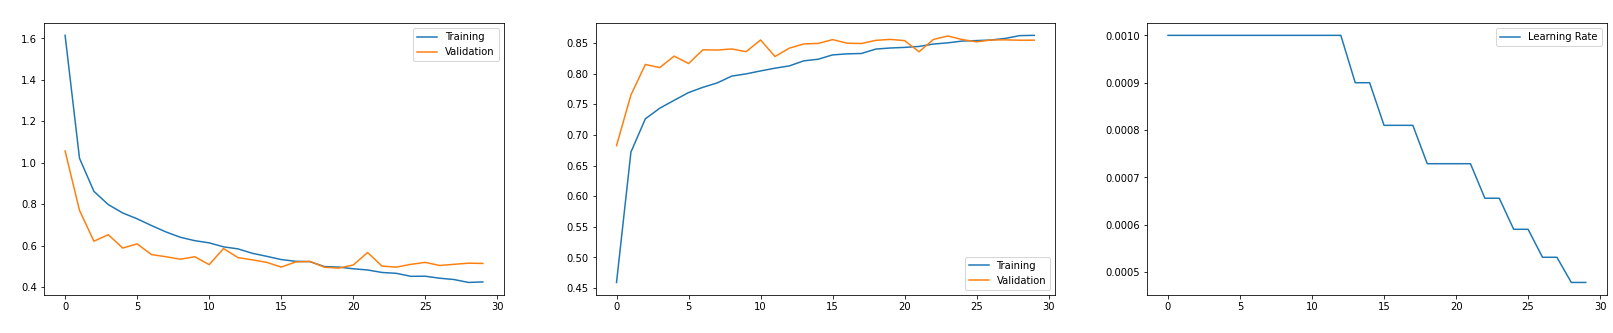

In [134]:
# Plots including the Learning Rate change thanks to the callback.
fig = plt.figure (figsize=(28, 5))
fig.add_subplot(131)
plt.plot(CNNhistory.history['loss'])
plt.plot(CNNhistory.history['val_loss'])
plt.title('CNN loss vs val_loss', color='white')
plt.xlabel('Epochs', color='white')
plt.ylabel('Loss', color='white')
plt.legend(['Training', 'Validation'])

fig.add_subplot(132)
plt.plot(CNNhistory.history['accuracy'])
plt.plot(CNNhistory.history['val_accuracy'])
plt.title('CNN accuracy vs val_accuracy', color='white')
plt.xlabel('Epochs', color='white')
plt.ylabel('Accuracy', color='white')
plt.legend(['Training', 'Validation'])

fig.add_subplot(133)
plt.plot(CNNhistory.history['lr'])
plt.title('CNN Learning Rate', color='white')
plt.xlabel('Epochs', color='white')
plt.ylabel('Learning Rate', color='white')
plt.legend(['Learning Rate'])

In [136]:
# Evaluating model on the test_set with 83% accuracy on the Test Set!!!!! 20% improvement compared to the MPL network.
modelCNN.evaluate(testX, testY)

814/814 [==============================] - 2s 2ms/step - loss: 0.6066 - accuracy: 0.8344


[0.6065896153450012, 0.8344345688819885]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [140]:
# Creation of new nets of both types and load of the best weights from the previous trainings.
new_MPLmodel = MPLnetwork(npixels)
new_MPLmodel.load_weights('/content/gdrive/MyDrive/Coursera/bestFlat/checkpoint')
new_CNNmodel = CNNnetwork(trainX[0].shape, 0.3)
new_CNNmodel.load_weights('/content/gdrive/MyDrive/Coursera/bestCNN/checkpoint')

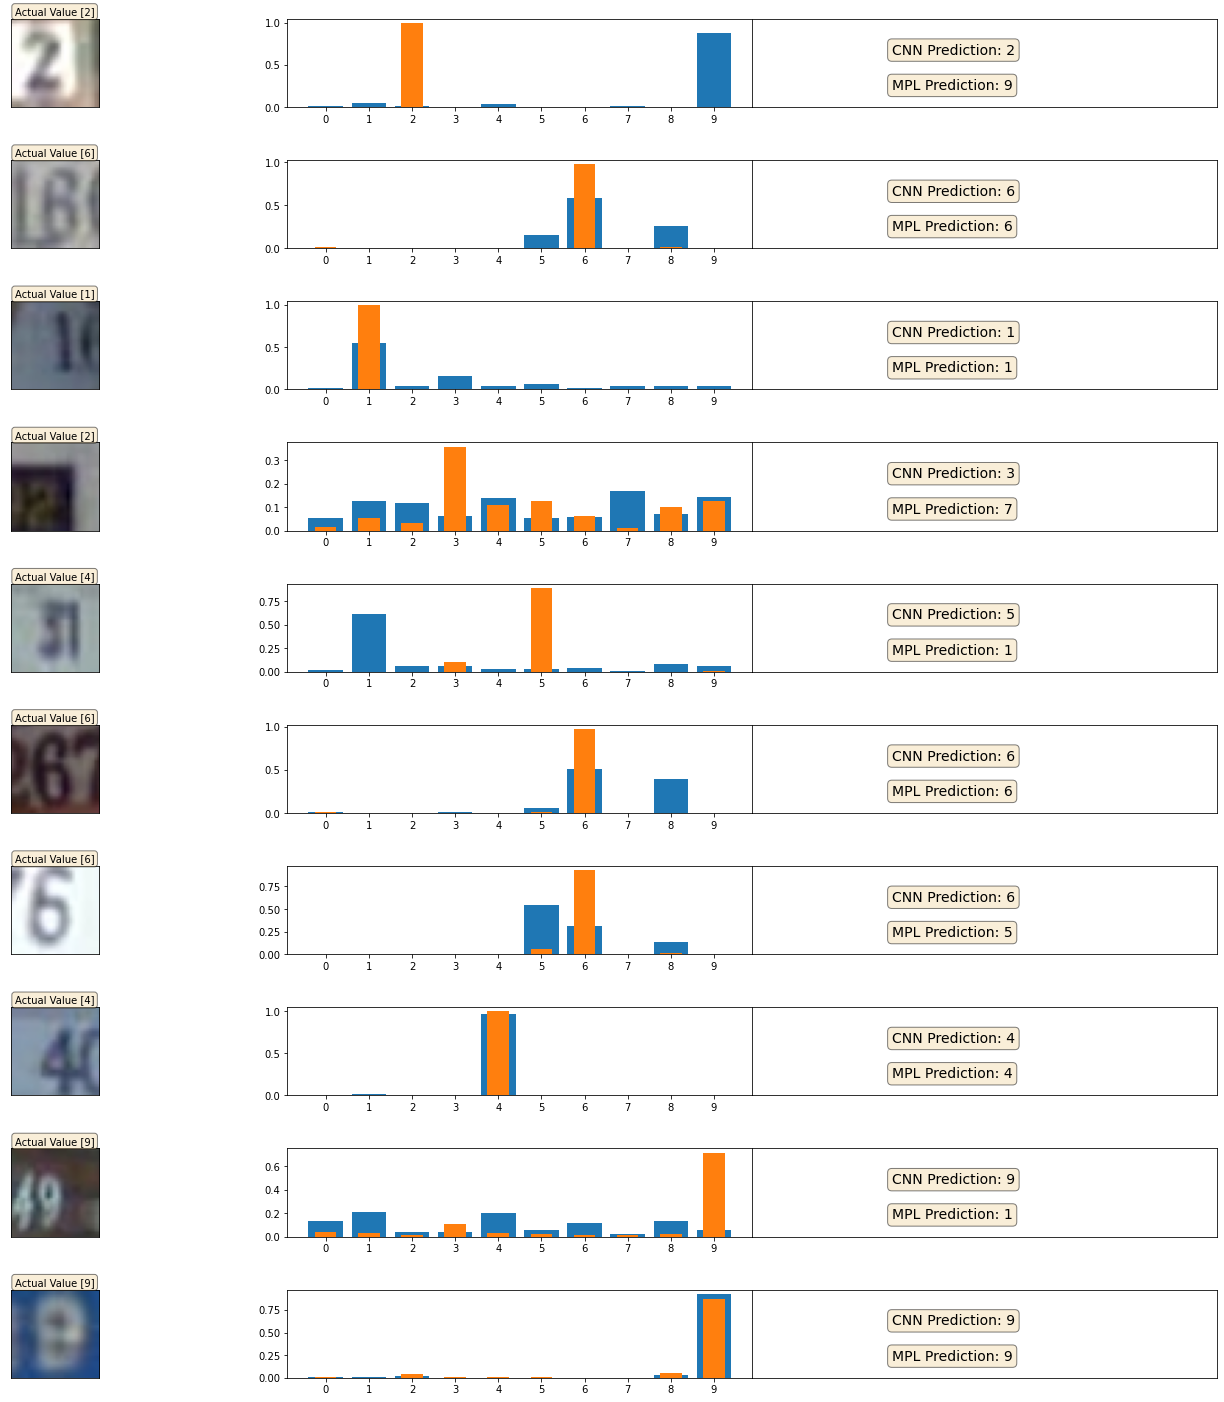

In [244]:
# Finding 10 random images from the 'Test Set' finding the predictions for both networks and plotting the results.
# NOTES:
  # To make the predictions we have to point to the right "test" matrices depending on the model:
  # To print the image we are pointig to the origial import of the data to show it in color.
  # The 'bar' plot is using the arrays of the prediction to show all the values found in the prediction.

fig, axes = plt.subplots(10,3, figsize=(25,25))
fig.subplots_adjust(hspace=0.6, wspace=0)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for i in range (10):
  randomizer = random.randrange(0, 26032, 1)
  actualdigit = test['y'][randomizer]

  MPLprediction = new_MPLmodel.predict(flatTestX[np.newaxis,randomizer,:])
  MPLnum = np.argmax(MPLprediction)

  CNNprediction = new_CNNmodel.predict(testX[np.newaxis,randomizer,...])
  CNNnum = np.argmax(CNNprediction)

  axes[i,0].imshow(np.squeeze(test['X'][:,:,:,randomizer]))
  axes[i,0].get_xaxis().set_visible(False)
  axes[i,0].get_yaxis().set_visible(False)
  axes[i,0].text(1.,-2, f'Actual Value {actualdigit}', fontsize=10, multialignment='center', bbox=props)
  axes[i,1].bar(np.arange(len(MPLprediction[0])), MPLprediction[0])
  axes[i,1].bar(np.arange(len(CNNprediction[0])), CNNprediction[0], width=0.5)
  axes[i,1].set_xticks(np.arange(len(MPLprediction[0])))
  axes[i,2].get_xaxis().set_visible(False)
  axes[i,2].get_yaxis().set_visible(False)
  axes[i,2].text (0.3,0.2, f'MPL Prediction: {MPLnum}', fontsize=14, multialignment='center', bbox=props)
  axes[i,2].text (0.3,0.6, f'CNN Prediction: {CNNnum}', fontsize=14, multialignment='center', bbox=props)

  #plt.imshow(test['X'][:,:,:,randomizer])